In [1]:
from kymatio.torch import Scattering1D, TimeFrequencyScattering
import torch

N = 2**10
sc = TimeFrequencyScattering(
    shape=N,
    J=6,
    J_fr=2,
    Q=(8, 1),
    Q_fr=1,
    T='global',
    F='global',
    format='time'
)

x = torch.randn(N, requires_grad=True)
Sx = sc(x)

Sx.norm().backward()
print(x.grad)
Jx = torch.autograd.functional.jacobian(sc, x)

tensor([-0.7253,  1.5869,  0.4639,  ...,  0.0044,  0.7657,  0.6758])


In [7]:
import functools
from kymatio.torch import Scattering1D, TimeFrequencyScattering
import torch

import cnn
import synth

n_densities = 7
n_slopes = 7
n_folds = n_densities * n_slopes
batch_size = 1

dataset = cnn.ChirpTextureDataModule(
    n_densities=n_densities,
    n_slopes=n_slopes,
    n_folds=n_folds,
    batch_size=batch_size)
dataset.setup()

sc = TimeFrequencyScattering(
    shape=(2**15),
    J=6,
    Q=(24, 2),
    Q_fr=2,
    J_fr=5,
    T='global',
    F='global',
    format='time',
)

def S_from_theta(theta, sc, dataset, seed):
    x = synth.generate_chirp_texture(
        theta_density=theta[0],
        theta_slope=theta[1],
        duration=dataset.train_ds.duration,
        event_duration=dataset.train_ds.event_duration,
        sr=dataset.train_ds.sr,
        fmin=dataset.train_ds.fmin,
        fmax=dataset.train_ds.fmax,
        n_events=dataset.train_ds.n_events,
        Q=dataset.train_ds.Q,
        hop_length=dataset.train_ds.hop_length,
        seed=seed,
    )
    return sc(x)

S_closure = lambda theta: S_from_theta(theta, sc, dataset, seed=0)


CQT kernels created, time used = 0.0231 seconds
CQT kernels created, time used = 0.0296 seconds
CQT kernels created, time used = 0.0202 seconds


In [8]:
theta = torch.tensor([0.5, 0.5])
J = torch.autograd.functional.jacobian(S_closure, theta)

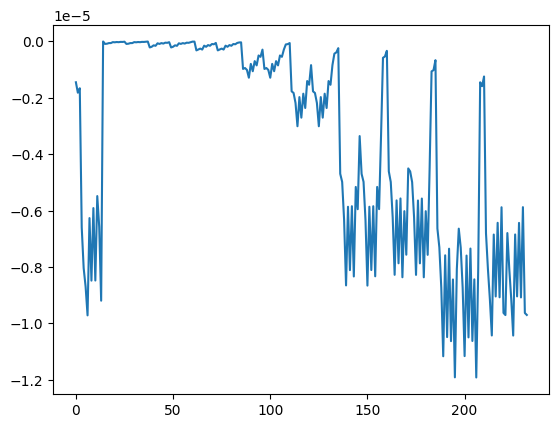

In [19]:
from matplotlib import pyplot as plt
plt.plot(J.detach().numpy()[1:, 0, 1])

In [21]:
x = torch.zeros(2**15)
Jx = torch.autograd.functional.jacobian(sc, x)

In [33]:
def x_from_theta(theta, dataset, seed):
    x = synth.generate_chirp_texture(
        theta_density=theta[0],
        theta_slope=theta[1],
        duration=dataset.train_ds.duration,
        event_duration=dataset.train_ds.event_duration,
        sr=dataset.train_ds.sr,
        fmin=dataset.train_ds.fmin,
        fmax=dataset.train_ds.fmax,
        n_events=dataset.train_ds.n_events,
        Q=dataset.train_ds.Q,
        hop_length=dataset.train_ds.hop_length,
        seed=seed,
    )
    return x

x_closure = lambda theta: x_from_theta(theta, dataset, seed=0)

In [36]:
Jtheta = torch.autograd.functional.jacobian(x_closure, theta, strategy='forward-mode', vectorize=True)

In [39]:
Jchained = Jx @ Jtheta

In [50]:
torch.linalg.norm(J-Jchained) / torch.linalg.norm(J)

tensor(0.3147)

In [52]:
Jchained

tensor([[[-1.2487e+01,  2.1848e-04]],

        [[ 0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0

In [53]:
34/42

0.8095238095238095

In [34]:

Jtheta = torch.autograd.functional.jacobian(x_closure, theta)

KeyboardInterrupt: 

In [66]:
import os

sav_dir = os.path.expanduser("~/Desktop")
density_idx = 0
slope_idx = 0
seed = 0

sav_name = "jacobian_density-{}_slope-{}_seed-{}.pt".format(
    density_idx, slope_idx, seed)
jac_dir = os.path.join(sav_dir, "jacobians_7x7")
os.makedirs(jac_dir, exist_ok=True)
sav_path = os.path.join(jac_dir, sav_name)
torch.save(J, sav_path)

In [67]:
Jbis = torch.load(sav_path)

In [71]:
Jbis.squeeze().shape

torch.Size([234, 2])